# Setup

## Imports

In [1]:
import os
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Device (GPU) Setup

In [2]:
device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Using device: {device}")

Using device: CPU


## Vocabulary Setup

In [3]:
vocabulary = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
              "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z",
              "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

vocabulary = sorted(vocabulary)

print(f"Total characters in the dataset: {len(vocabulary)}")
print(f"Vocabulary: {''.join(vocabulary)}")

# char_to_num mapping
char_to_num = {char: i for i, char in enumerate(vocabulary)}
num_to_char = {i: char for i, char in enumerate(vocabulary)}

print("\nCharacter to Number Mapping (char_to_num):")
print(char_to_num)

print("\nNumber to Character Mapping (num_to_char):")
print(num_to_char)

Total characters in the dataset: 36
Vocabulary: 0123456789abcdefghijklmnopqrstuvwxyz

Character to Number Mapping (char_to_num):
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}

Number to Character Mapping (num_to_char):
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}


## Read Images

In [4]:
def read_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        images.append(img)
    return images

Number of training images: 8010
Found 8010 labels in the training folder.


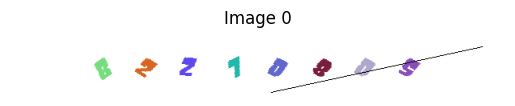

Label: b2z7d8ds


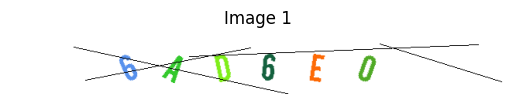

Label: 6ad6e0


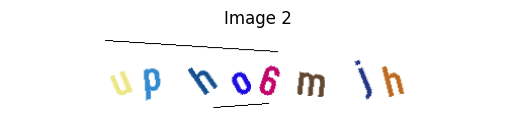

Label: upho6mjh


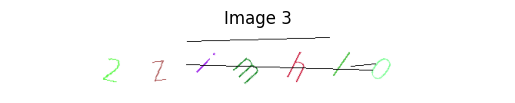

Label: 2zimhl0


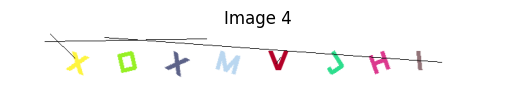

Label: xdxmvjhi


In [5]:
train_data_path = "../data/main/train/"
train_images = read_images_from_folder(train_data_path)
print(f"Number of training images: {len(train_images)}")

image_paths = glob.glob(os.path.join(train_data_path, "*.png"))
train_labels = [os.path.basename(path).split('-')[0] for path in image_paths]
print(f"Found {len(train_labels)} labels in the training folder.")

# Display first 5 images
for i in range(5):
    plt.imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i}")
    plt.axis('off')
    plt.show()
    print(f"Label: {train_labels[i]}") # Display first 5 labels

# Preprocessing

## Noise Reduction

In [6]:
# Noise reduction function (For now not used)

def denoise(img):
    img = cv2.medianBlur(img, 3)

    img = cv2.GaussianBlur(img, (3, 3), 0)

    return img

(np.float64(-0.5), np.float64(619.5), np.float64(79.5), np.float64(-0.5))

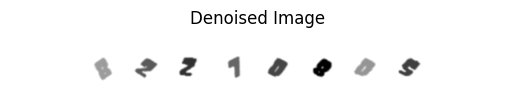

In [7]:
# Example usage

denoised_img1 = denoise(train_images[0])
plt.imshow(cv2.cvtColor(denoised_img1, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.title("Denoised Image")
plt.axis('off')

## Remove Black Lines and Inpaint

In [8]:
# Function to remove black lines and inpaint, returns a grayscale image (Mainly used for preprocessing)

def remove_black_lines_and_inpaint(img, inpaint_radius=1):
    black_mask = cv2.inRange(img, (0, 0, 0), (4, 4, 4)) # Adjust threshold as needed
    inpainted_img = cv2.inpaint(img, black_mask, inpaintRadius=inpaint_radius, flags=cv2.INPAINT_TELEA)
    return cv2.cvtColor(inpainted_img, cv2.COLOR_BGR2GRAY)

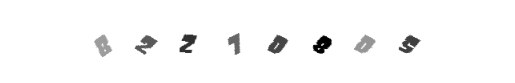

In [9]:
# Example usage

inpainted_img = remove_black_lines_and_inpaint(train_images[0])
plt.imshow(inpainted_img, cmap='gray')
plt.axis('off')
plt.show()

## Tokenization

In [10]:
def tokenize(img):
    """
    Segments a CAPTCHA image into individual character images.
    Returns a list of 80x80 grayscale character images (white background).
    """
    # Ensure grayscale
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Enhance contrast and binarize
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(blur)
    binary = cv2.adaptiveThreshold(
        clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, blockSize=21, C=5
    )

    # Dilation to thicken strokes
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    binary = cv2.dilate(binary, kernel, iterations=1)

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
    H, W = img.shape
    area = H * W
    chars = []

    for i in range(1, num_labels):  # skip background
        x, y, w, h, a = stats[i]
        # Filter out noise and oversized blobs
        if a < 0.001 * area or a > 0.35 * area or w <= 1 or h <= 1:
            continue

        # Extract character mask and crop
        comp_mask = (labels[y:y+h, x:x+w] == i).astype(np.uint8) * 255
        gray_crop = img[y:y+h, x:x+w]
        isolated = np.where(comp_mask == 255, gray_crop, 255).astype(np.uint8)

        # Resize and pad to 80x80
        scale = 96 / max(h, w)
        new_w = max(1, int(round(w * scale)))
        new_h = max(1, int(round(h * scale)))
        resized = cv2.resize(isolated, (new_w, new_h))

        canvas = np.ones((100, 100), dtype=np.uint8) * 255
        y_off, x_off = (100 - new_h) // 2, (100 - new_w) // 2
        canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized

        chars.append((x, canvas))

    # Sort left-to-right and return only images
    chars = [c for x, c in sorted(chars, key=lambda t: t[0])]
    return chars

In [11]:
def save_tokenized_images(img, label, output_dir):
    chars = tokenize(img)
    if len(chars) != len(label):
        # Ignore this data point if mismatch
        return
    for i, char_img in enumerate(chars):
        # Binarize the character image before saving
        _, binarized = cv2.threshold(char_img, 253, 255, cv2.THRESH_BINARY)
        char_label = label[i]
        char_folder = os.path.join(output_dir, f"char_{char_label}")
        os.makedirs(char_folder, exist_ok=True)
        filename = f"{label}_{i}.png"
        cv2.imwrite(os.path.join(char_folder, filename), binarized)

In [12]:
def show_tokenized(chars):
    plt.figure(figsize=(len(chars)*2, 2))  # adjust width dynamically
    for i, c in enumerate(chars):
        plt.subplot(1, len(chars), i + 1)
        plt.imshow(c, cmap='gray')
        plt.axis('off')
    plt.show()

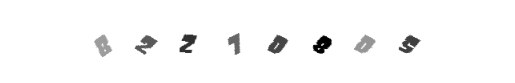

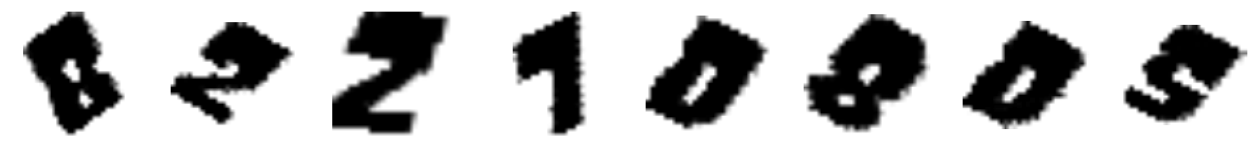

In [13]:
# Example usage

sample_image = remove_black_lines_and_inpaint(train_images[0])
tokenized_chars = tokenize(sample_image)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')   # hide axes
plt.show()

show_tokenized(tokenized_chars)

In [14]:
for img, label in zip(train_images, train_labels):
    print(f"Processing label: {label}")
    img = remove_black_lines_and_inpaint(img)
    save_tokenized_images(img, label, "../data/char_train/")

Processing label: b2z7d8ds
Processing label: 6ad6e0
Processing label: upho6mjh
Processing label: 2zimhl0
Processing label: xdxmvjhi
Processing label: s2he
Processing label: 6udel
Processing label: stx1upye
Processing label: citp
Processing label: nip6
Processing label: vmii
Processing label: 4rcb
Processing label: bgttx
Processing label: arix
Processing label: 1d4rh
Processing label: d8wo4
Processing label: yyvv0kit
Processing label: e842nw3
Processing label: mvjjpt
Processing label: y0cq
Processing label: hdu5
Processing label: 8d2y98
Processing label: aswhu3
Processing label: b764czl
Processing label: 8hek
Processing label: vpqdhv9
Processing label: 6d6wnrn
Processing label: j4i7178
Processing label: qkyk15f
Processing label: dwzv
Processing label: 9a2xdo
Processing label: usskt
Processing label: wf6eq6y0
Processing label: d9crqi1
Processing label: 2qf7lro
Processing label: x7cklg
Processing label: q3389dmi
Processing label: pk0k8c3
Processing label: 2b8aok
Processing label: nvqhrsga

## Training Characters

In [15]:
train_char_images = []
train_char_labels = []
char_dir = "../data/char_train/"

for label_folder in os.listdir(char_dir):
    folder_path = os.path.join(char_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue
    # Extract label from folder name
    label = label_folder.replace("char_", "")
    # Get all PNG files in the folder
    for img_path in glob.glob(os.path.join(folder_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        train_char_images.append(img)
        train_char_labels.append(label)

print(f"Total character images loaded: {len(train_char_images)}")

Total character images loaded: 40243


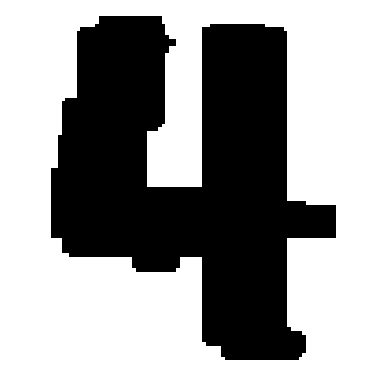

Label: 4


In [16]:
plt.imshow(train_char_images[0], cmap='gray')
plt.axis('off')
plt.show()
print(f"Label: {train_char_labels[0]}")

## Augmentation

In [17]:
def augment(img):
    aug_img = img.copy()

    # Random horizontal flip
    if random.random() < 0.3:
        aug_img = cv2.flip(aug_img, 1)

    # Random rotation (between 30 and 60 degrees, either direction)
    if random.random() < 0.3:
        angle = random.uniform(30, 60) * random.choice([-1, 1])
        M = cv2.getRotationMatrix2D((aug_img.shape[1] // 2, aug_img.shape[0] // 2), angle, 1)
        aug_img = cv2.warpAffine(aug_img, M, (aug_img.shape[1], aug_img.shape[0]), borderValue=255)

    # Random warp affine (shear/distort)
    if random.random() < 0.3:
        rows, cols = aug_img.shape
        pts1 = np.float32([[0,0], [cols-1,0], [0,rows-1]])
        pt_shift = random.randint(-10, 10)
        pts2 = np.float32([[0+pt_shift,0], [cols-1,0+pt_shift], [0,rows-1+pt_shift]])
        M = cv2.getAffineTransform(pts1, pts2)
        aug_img = cv2.warpAffine(aug_img, M, (cols, rows), borderValue=255)

    # Random Gaussian noise
    if random.random() < 0.3:
        noise = np.random.normal(0, 10, aug_img.shape).astype(np.int16)
        aug_img = np.clip(aug_img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    return aug_img

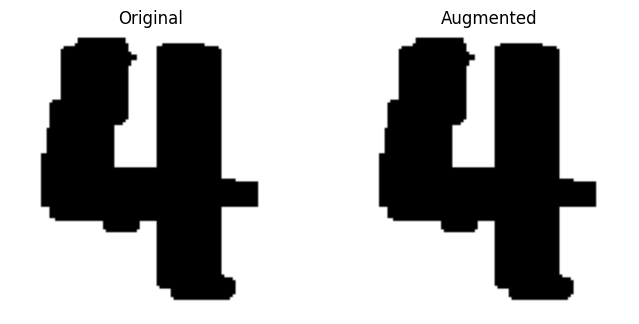

In [18]:
sample_image = train_char_images[0]
augmented_image = augment(sample_image)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(augmented_image, cmap='gray')
plt.title("Augmented")
plt.axis('off')
plt.show()

### Add Augmentations to Training Characters

In [19]:
if 'augmentations_applied' not in globals():
    augmented_char_images = []
    augmented_char_labels = []
    augmentations_applied = True
    for img, label in zip(train_char_images, train_char_labels):
        # Original image
        augmented_char_images.append(img)
        augmented_char_labels.append(label)
        # Augmented image
        aug_img = augment(img)
        augmented_char_images.append(aug_img)
        augmented_char_labels.append(label)
    train_char_images = augmented_char_images
    train_char_labels = augmented_char_labels
else:
    print("Augmentation already applied, skipping.")

print(f"Total images after augmentation: {len(train_char_images)}")

Total images after augmentation: 80486


Total characters: 80486
Unique characters: 36
Character distribution:
0: 2292
1: 2312
2: 2132
3: 2324
4: 2240
5: 2192
6: 2288
7: 2156
8: 2214
9: 2248
a: 2190
b: 2324
c: 2230
d: 2320
e: 2318
f: 2238
g: 2296
h: 2246
i: 1948
j: 1934
k: 2214
l: 2244
m: 2226
n: 2358
o: 2258
p: 2306
q: 2352
r: 2218
s: 2190
t: 2264
u: 2180
v: 2292
w: 2260
x: 2320
y: 2152
z: 2210


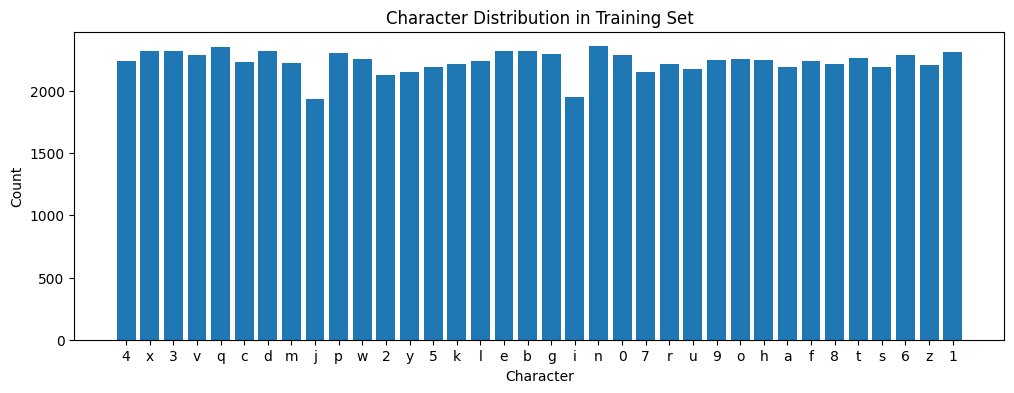

In [24]:
from collections import Counter

# Assuming train_char_labels is your list of character labels
char_counts = Counter(train_char_labels)

print("Total characters:", len(train_char_labels))
print("Unique characters:", len(char_counts))
print("Character distribution:")
for char, count in sorted(char_counts.items()):
    print(f"{char}: {count}")

# Optional: visualize as a bar chart
plt.figure(figsize=(12, 4))
plt.bar(char_counts.keys(), char_counts.values())
plt.xlabel("Character")
plt.ylabel("Count")
plt.title("Character Distribution in Training Set")
plt.show()

### Reshape to Add Channel Dimension

In [ ]:
X = np.array(train_char_images, dtype=np.float32) / 255.0
X = X[..., np.newaxis]  # Add channel dimension for grayscale

print("X shape:", X.shape)
print(X[0].shape)

y = np.array([char_to_num[label] for label in train_char_labels], dtype=np.float32)
print("y shape:", y.shape)
print(y[0])

X shape: (80486, 100, 100, 1)
(100, 100, 1)
y shape: (80486,)
4


# Model

## Definition

In [46]:
class CharacterClassifier(keras.Model):
    def __init__(self, input_shape=(100, 100, 1), output_classes=36):
        super(CharacterClassifier, self).__init__()

        # Layer Block 1
        self.block1 = keras.Sequential([
            layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(32, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(2),
            layers.Dropout(0.1)
        ])

        # Layer Block 2
        self.block2 = keras.Sequential([
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(2),
            layers.Dropout(0.15)
        ])

        # Layer Block 3
        self.block3 = keras.Sequential([
            layers.Conv2D(128, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(2),
            layers.Dropout(0.2)
        ])

        # Layer Block 4
        self.block4 = keras.Sequential([
            layers.Conv2D(256, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(2),
            layers.Dropout(0.2)
        ])

        # Fully Connected Layers
        self.fully_connected = keras.Sequential([
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(output_classes, activation='softmax')
        ])
    
    def call(self, input_image, training=False):
        x = self.block1(input_image, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.block4(x, training=training)
        x = self.fully_connected(x, training=training)
        return x

## Training

In [48]:
model = CharacterClassifier()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# history = model.fit(
#     images, labels,
#     epochs=10,
#     batch_size=32,
# )

# Now you can train your model
history = model.fit(
    X, y,
    epochs=10,
    batch_size=32,
)

Epoch 1/10
1067/2516 ━━━━━━━━━━━━━━━━━━━━ 7:35 315ms/step - accuracy: 0.0278 - loss: 3.9079

KeyboardInterrupt: 

# Inference

In [ ]:
# Select a test character image (e.g., images[0])
test_img = images[0]  # shape: (100, 100), grayscale

# Preprocess: add batch and channel dimensions
test_input = np.expand_dims(test_img, axis=(0, -1))  # shape: (1, 100, 100, 1)

# Set model to evaluation mode and predict
pred_probs = model(test_input, training=False).numpy()
pred_class = np.argmax(pred_probs, axis=1)[0]

# Map predicted class back to character
num_to_char = {v: k for k, v in char_to_num.items()}
pred_char = num_to_char[pred_class]

print(f"Predicted character: {pred_char}")
plt.imshow(test_img, cmap='gray')
plt.axis('off')
plt.title(f"Prediction: {pred_char}")
plt.show()

In [ ]:
print(np.isnan(X).sum(), np.isinf(X).sum())

0 0
